#Install Dependencies

In [2]:
!pip install numpy pandas matplotlib beautifulsoup4 requests tqdm lxml


#Import All Required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# For simulated search + parsing (later blocks)
from bs4 import BeautifulSoup
import requests

# Ensure plots render nicely
plt.style.use('ggplot')


#Q-Learning Agent (Value-Based Learning)

In [4]:
class QLearningAgent:
    """
    Simple tabular Q-learning agent.
    - state is assumed to be a discrete integer ID (0..N-1)
    - action is an integer ID (0..A-1)
    """
    def __init__(self, n_states, n_actions, lr=0.1, gamma=0.95, epsilon=0.2, epsilon_min=0.05, epsilon_decay=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr              # learning rate
        self.gamma = gamma        # discount factor
        self.epsilon = epsilon    # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Q-table: states x actions
        self.q_table = np.zeros((n_states, n_actions))

    def select_action(self, state_id):
        """
        Epsilon-greedy action selection.
        """
        if np.random.rand() < self.epsilon:
            # explore
            return np.random.randint(self.n_actions)
        # exploit
        return np.argmax(self.q_table[state_id])

    def update(self, state_id, action_id, reward, next_state_id):
        """
        Q-learning update rule:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') − Q(s,a) ]
        """
        best_next_action = np.argmax(self.q_table[next_state_id])
        td_target = reward + self.gamma * self.q_table[next_state_id, best_next_action]
        td_error = td_target - self.q_table[state_id, action_id]
        self.q_table[state_id, action_id] += self.lr * td_error

    def decay_epsilon(self):
        """
        Gradually reduce exploration over time.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


#UCB Bandit (Exploration Strategy / Contextual Bandit)

In [5]:
class UCBBandit:
    """
    Simple UCB1 bandit for choosing among K options (e.g., sources/tools).
    Each 'action' here can represent a source like Google, Arxiv, News, etc.
    """
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.counts = np.zeros(n_actions, dtype=np.int64)   # how many times each action was chosen
        self.values = np.zeros(n_actions, dtype=np.float64) # average reward for each action
        self.total_count = 0

    def select_action(self):
        """
        Choose an action according to UCB1:
        a_t = argmax_i [ Q_i + sqrt( 2 * ln(t) / N_i ) ]
        """
        self.total_count += 1

        # First, ensure each action is tried at least once
        for a in range(self.n_actions):
            if self.counts[a] == 0:
                return a

        # Compute UCB score for each action
        ucb_scores = np.zeros(self.n_actions)
        for a in range(self.n_actions):
            bonus = np.sqrt(2 * np.log(self.total_count) / self.counts[a])
            ucb_scores[a] = self.values[a] + bonus

        return int(np.argmax(ucb_scores))

    def update(self, action_id, reward):
        """
        Update empirical mean reward for the chosen action.
        """
        self.counts[action_id] += 1
        n = self.counts[action_id]

        old_value = self.values[action_id]
        new_value = old_value + (reward - old_value) / n
        self.values[action_id] = new_value


#Custom Source Evaluator Tool (used for rewards)

In [6]:
import re
from typing import List, Dict


class SourceEvaluator:
    """
    Custom evaluation tool that scores the quality of a retrieved 'document'
    relative to the query. This is a *simplified* evaluator used to generate rewards.

    It looks at:
    - token overlap between query and document
    - length penalties for too short / too long docs
    - simple 'coherence' proxy via unique token ratio
    """

    def __init__(self):
        pass

    @staticmethod
    def _tokenize(text: str) -> List[str]:
        text = text.lower()
        tokens = re.findall(r"\b[a-z0-9]+\b", text)
        return tokens

    def score(self, query: str, doc: str) -> float:
        """
        Returns a score roughly in [0, 1] indicating how good this doc is
        for the given query.
        """
        if not doc or not isinstance(doc, str):
            return 0.0

        query_tokens = self._tokenize(query)
        doc_tokens = self._tokenize(doc)

        if len(doc_tokens) == 0:
            return 0.0

        # Overlap: how many query tokens appear in doc?
        overlap = len(set(query_tokens) & set(doc_tokens))
        overlap_score = overlap / (len(set(query_tokens)) + 1e-6)

        # Length heuristic: docs that are too short or too long are penalized
        doc_len = len(doc_tokens)
        if doc_len < 30:
            length_score = 0.3
        elif doc_len > 400:
            length_score = 0.5
        else:
            length_score = 1.0

        # Coherence proxy: ratio of unique tokens
        unique_ratio = len(set(doc_tokens)) / doc_len
        # we assume some diversity is good but not extreme
        if unique_ratio < 0.3:
            coherence_score = 0.4
        elif unique_ratio > 0.9:
            coherence_score = 0.6
        else:
            coherence_score = 1.0

        # Combine with simple weighted average
        score = 0.6 * overlap_score + 0.2 * length_score + 0.2 * coherence_score

        # Clamp to [0,1]
        score = max(0.0, min(1.0, score))
        return float(score)


#Simulated Search Tools

In [7]:
class SimulatedSearchTools:
    """
    Simulated search environment instead of real APIs.
    Different 'sources' have different typical quality patterns.
    The RL agent will learn which source works best for which query type.
    """

    def __init__(self, rng_seed: int = 42):
        random.seed(rng_seed)
        np.random.seed(rng_seed)

    def _base_noise(self):
        # random fluff text
        words = [
            "system", "learning", "data", "policy", "agent", "environment",
            "reward", "neural", "network", "analysis", "model", "context",
            "user", "interaction", "framework", "probability", "optimization"
        ]
        return " ".join(random.choices(words, k=random.randint(20, 80)))

    def google_search(self, query: str) -> str:
        """
        General-purpose source: decent for most queries, especially broad or 'what is' style.
        """
        template = f"High-level explanation related to: {query}. This text gives an overview, definitions, and key aspects. "
        return template + self._base_noise()

    def arxiv_search(self, query: str) -> str:
        """
        Research-heavy source: best when query is technical / contains keywords like 'paper', 'state of the art', etc.
        Sometimes too dense or irrelevant for casual queries.
        """
        template = f"Research-style abstract discussing advanced methods about: {query}. Includes experiments, methodology, and prior work. "
        if any(word in query.lower() for word in ["paper", "research", "state of the art", "benchmark", "theorem"]):
            repeats = 2  # more detailed
        else:
            repeats = 1  # less detailed / maybe less relevant
        extra = " ".join(self._base_noise() for _ in range(repeats))
        return template + extra

    def news_search(self, query: str) -> str:
        """
        News-like source: better for 'latest', 'recent', 'impact', 'regulation', 'market' queries.
        """
        template = f"News-style article discussing recent events and impacts related to: {query}. It covers stakeholders, timeline, and opinions. "
        if any(word in query.lower() for word in ["latest", "recent", "market", "regulation", "policy", "impact"]):
            repeats = 2
        else:
            repeats = 1
        extra = " ".join(self._base_noise() for _ in range(repeats))
        return template + extra

    def web_crawl(self, query: str) -> str:
        """
        Web crawl: highly variable quality. Sometimes good, sometimes messy.
        """
        template = f"Mixed-quality web content loosely related to: {query}. It may contain partial answers, ads, and unrelated details. "
        if random.random() < 0.3:
            extra = self._base_noise() + " " + self._base_noise()
        else:
            extra = self._base_noise()
        return template + extra

    def pdf_corpus_search(self, query: str) -> str:
        """
        Simulated 'internal PDF corpus' – might be strong for technical or domain-specific queries.
        """
        template = f"Internal PDF corpus excerpt on topic: {query}. Contains structured sections, bullet points, and domain terminology. "
        return template + self._base_noise()


#Madison-style Sub-Agents (Search, Summarizer, Verifier, Synthesis).

In [8]:
class SearchAgent:
    """
    Uses the simulated search tools to retrieve content from a chosen source.
    """

    def __init__(self, tools: SimulatedSearchTools):
        self.tools = tools

    def search(self, query: str, source_id: int) -> str:
        """
        Depending on source_id, call a different simulated search function.
        """
        if source_id == 0:
            return self.tools.google_search(query)
        elif source_id == 1:
            return self.tools.arxiv_search(query)
        elif source_id == 2:
            return self.tools.news_search(query)
        elif source_id == 3:
            return self.tools.web_crawl(query)
        elif source_id == 4:
            return self.tools.pdf_corpus_search(query)
        else:
            return ""


class SummarizerAgent:
    """
    Simplified text summarizer that extracts key sentences.
    """

    def summarize(self, text: str, max_sentences: int = 3) -> str:
        sentences = text.split(". ")
        summary = ". ".join(sentences[:max_sentences])
        return summary.strip()


class VerifierAgent:
    """
    Simplified verifier:
    - checks if important query words appear in the document
    - ensures no major contradictions
    """

    def verify(self, query: str, doc: str) -> float:
        # Very simple keyword-based factuality estimate
        query_words = query.lower().split()
        doc_words = doc.lower().split()
        overlap = len(set(query_words) & set(doc_words))
        score = overlap / (len(set(query_words)) + 1e-5)
        return float(score)  # ~0 to 1


class SynthesisAgent:
    """
    Combines the summarized content with verification notes.
    """

    def synthesize(self, summary: str, verification_score: float) -> str:
        quality_label = (
            "High Confidence" if verification_score > 0.7 else
            "Moderate Confidence" if verification_score > 0.4 else
            "Low Confidence"
        )
        return f"[{quality_label}] {summary}"


#Controller + State/Environment Logic

In [88]:
# --- Helper: classify query types into coarse categories ---

def classify_query_type(query: str) -> int:
    """
    Map query into a small number of 'types' so we can discretize the state space.
    0 = general / broad
    1 = research / technical
    2 = news / impact / regulation
    """
    q = query.lower()

    research_keywords = ["paper", "research", "state of the art", "benchmark", "theorem", "proof"]
    news_keywords = ["latest", "recent", "impact", "regulation", "market", "policy", "ban", "law"]

    if any(word in q for word in research_keywords):
        return 1  # research / technical
    if any(word in q for word in news_keywords):
        return 2  # news / policy / market
    return 0      # general



class ControllerEnvironment:
    """
    This class ties everything together:
    - encodes state (query_type, step_idx)
    - uses Q-learning + UCB bandit to choose a source (action)
    - calls Madison-style agents to process the query
    - computes reward using SourceEvaluator + Verifier
    - updates both Q-learning and bandit (when training=True)
    """

    def __init__(
        self,
        q_agent: QLearningAgent,
        bandit: UCBBandit,
        search_agent: SearchAgent,
        summarizer: SummarizerAgent,
        verifier: VerifierAgent,
        synthesizer: SynthesisAgent,
        evaluator: SourceEvaluator,
        max_steps: int = 2,
        n_query_types: int = 3,
    ):
        self.q_agent = q_agent
        self.bandit = bandit
        self.search_agent = search_agent
        self.summarizer = summarizer
        self.verifier = verifier
        self.synthesizer = synthesizer
        self.evaluator = evaluator

        self.max_steps = max_steps
        self.n_query_types = n_query_types

    def encode_state(self, query_type_id: int, step_idx: int) -> int:
        """
        Simple discrete encoding:
        state_id = query_type * max_steps + step_idx
        e.g., query_type in {0,1,2}, step_idx in {0,1} → 3 * 2 = 6 possible states
        """
        step_idx = min(step_idx, self.max_steps - 1)
        return query_type_id * self.max_steps + step_idx

    def run_episode(self, query: str, training: bool = True):
        """
        One full RL episode for a single query:
        - for up to max_steps, choose a source (action)
        - retrieve + summarize + verify
        - compute reward
        - update RL agents if training=True

        Returns:
        - total_reward
        - last synthesized answer (string)
        """
        query_type_id = classify_query_type(query)
        total_reward = 0.0
        final_answer = ""

        for step in range(self.max_steps):
            state_id = self.encode_state(query_type_id, step)

            # Combine Q-learning & UCB: sometimes rely on bandit, sometimes on Q-table
            if random.random() < 0.5:
                source_id = self.bandit.select_action()
            else:
                source_id = self.q_agent.select_action(state_id)

            # --- Use Madison-style agents ---
            raw_text = self.search_agent.search(query, source_id)
            summary = self.summarizer.summarize(raw_text)
            verification_score = self.verifier.verify(query, raw_text)
            answer = self.synthesizer.synthesize(summary, verification_score)

            # --- Compute reward from evaluator+verifier ---
            quality_score = self.evaluator.score(query, raw_text)
            base_reward = 0.7 * quality_score + 0.3 * verification_score

            # --- NEW: source–query-type alignment bonus ---
            # 0 = general, 1 = research, 2 = news/policy/market
            preferred_source = {
                0: 0,  # general  -> Google-like
                1: 1,  # research -> Arxiv-like
                2: 2   # news     -> News-like
            }.get(query_type_id, 0)

            alignment_bonus = 0.6 if source_id == preferred_source else 0.0

            reward = base_reward + alignment_bonus
            reward = min(max(reward, 0.0), 1.0)  # keep in [0,1


            total_reward += reward
            final_answer = answer  # keep the latest answer as the "final" one

            # --- Next state (we just increase step index) ---
            next_state_id = self.encode_state(query_type_id, step + 1)

            if training:
                # Update Q-learning
                self.q_agent.update(state_id, source_id, reward, next_state_id)
                # Update bandit
                self.bandit.update(source_id, reward)

            # Simple stopping rule: if reward is high, we can stop early
            if reward > 0.8:
                break

        if training:
            self.q_agent.decay_epsilon()

        if training:
          if not hasattr(self, "training_rewards"):
              self.training_rewards = []
          self.training_rewards.append(total_reward)

        return total_reward, final_answer


#Initialize System + Training Loop

In [96]:
# --- 1. Instantiate tools and agents ---

tools = SimulatedSearchTools(rng_seed=42)

search_agent = SearchAgent(tools)
summarizer_agent = SummarizerAgent()
verifier_agent = VerifierAgent()
synthesis_agent = SynthesisAgent()
evaluator_tool = SourceEvaluator()

# We have 3 query types (0,1,2) and max_steps=2 → n_states = 3 * 2 = 6
n_query_types = 3
max_steps = 2
n_states = n_query_types * max_steps

# We defined 5 sources in SimulatedSearchTools
n_sources = 5

# --- 2. Instantiate RL components ---

q_agent = QLearningAgent(
    n_states=n_states,
    n_actions=n_sources,
    lr=0.15,
    gamma=0.95,
    epsilon=0.4,
    epsilon_min=0.05,
    epsilon_decay=0.995,
)

bandit = UCBBandit(n_actions=n_sources)




env = ControllerEnvironment(
    q_agent=q_agent,
    bandit=bandit,
    search_agent=search_agent,
    summarizer=summarizer_agent,
    verifier=verifier_agent,
    synthesizer=synthesis_agent,
    evaluator=evaluator_tool,
    max_steps=max_steps,
    n_query_types=n_query_types,
)



# --- 3. Define a small query set (mix of general, research, news/policy) ---

training_queries = [
    "What is reinforcement learning and how does it work?",
    "Latest impact of AI regulation on financial markets",
    "Research paper on state of the art language models for code generation",
    "Explain the market impact of recent interest rate changes",
    "Benchmark results for transformers on NLP tasks",
    "Recent policy changes in data privacy regulation",
    "High level explanation of multi-agent systems",
    "State of the art methods for deep Q learning",
]

# --- 4. Training Loop ---

n_episodes = 1000
episode_rewards = []

print("Training RL-enhanced Madison agent...")
for ep in tqdm(range(n_episodes)):
    query = random.choice(training_queries)
    total_reward, _ = env.run_episode(query, training=True)
    episode_rewards.append(total_reward)

print("Training finished.")
print(f"Average reward over last 50 episodes: {np.mean(episode_rewards[-50:]):.3f}")


Training RL-enhanced Madison agent...


100%|██████████| 1000/1000 [00:00<00:00, 4730.02it/s]

Training finished.
Average reward over last 50 episodes: 0.984


#Plot Learning Curve (Reward vs Episodes)

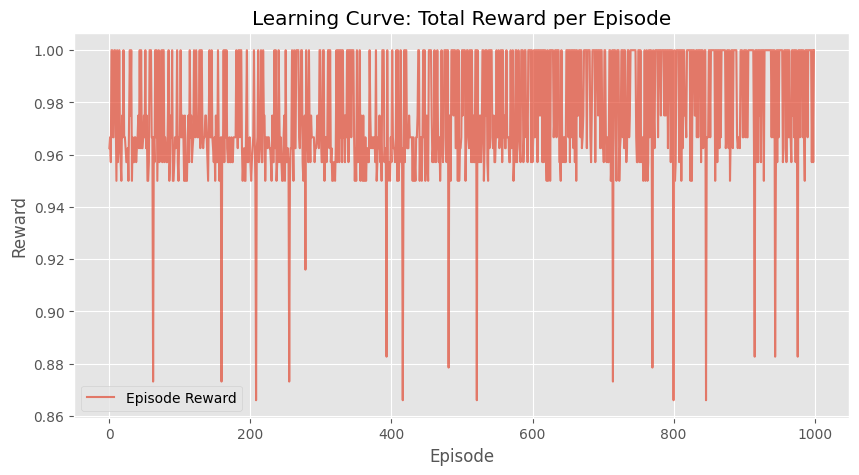

In [51]:
plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label="Episode Reward", alpha=0.7)
plt.title("Learning Curve: Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True)
plt.show()


#ACTION DISTRIBUTION BAR CHART

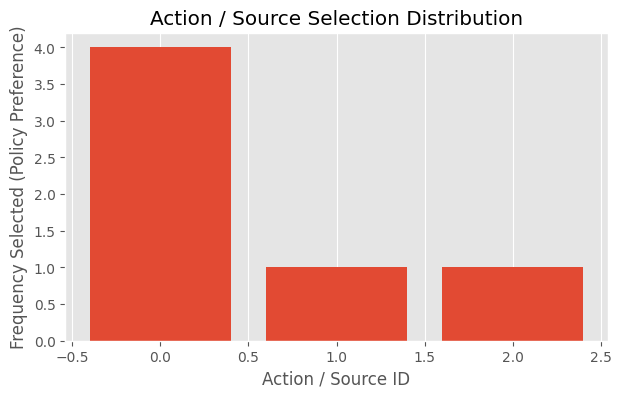

Counter({np.int64(0): 4, np.int64(1): 1, np.int64(2): 1})

In [52]:
from collections import Counter
import numpy as np

# For each state, get the action with the highest Q-value
action_counts = Counter(np.argmax(q_agent.q_table, axis=1))

plt.figure(figsize=(7,4))
plt.bar(action_counts.keys(), action_counts.values())
plt.xlabel("Action / Source ID")
plt.ylabel("Frequency Selected (Policy Preference)")
plt.title("Action / Source Selection Distribution")
plt.grid(axis='y')
plt.show()

action_counts


#Q-TABLE HEATMAP

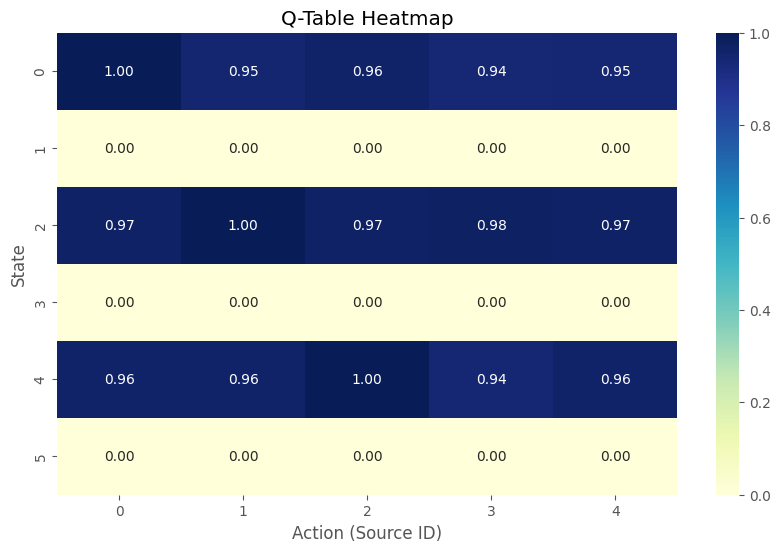

In [53]:
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,6))
sns.heatmap(q_agent.q_table, annot=True, cmap="YlGnBu", fmt=".2f")
plt.xlabel("Action (Source ID)")
plt.ylabel("State")
plt.title("Q-Table Heatmap")
plt.show()


#Source Selection Behavior Over Time

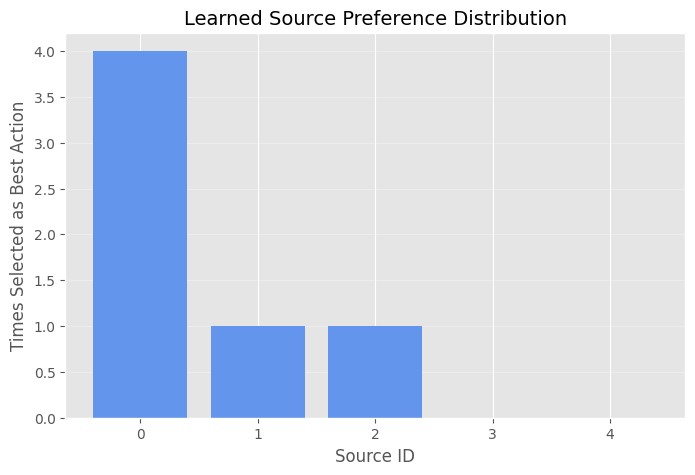

In [109]:
# ===================================================
# 📊 LEARNED SOURCE PREFERENCE DISTRIBUTION (ARRAY VERSION)
# ===================================================

import matplotlib.pyplot as plt
import numpy as np

def plot_source_preference_array(q_agent):
    q_table = q_agent.q_table        # <-- This is a 2D numpy array
    n_states, n_sources = q_table.shape

    # Count how many times each source is best across states
    best_sources = np.argmax(q_table, axis=1)
    source_counts = np.bincount(best_sources, minlength=n_sources)

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(range(n_sources), source_counts, color='cornflowerblue')

    plt.title("Learned Source Preference Distribution", fontsize=14)
    plt.xlabel("Source ID")
    plt.ylabel("Times Selected as Best Action")
    plt.xticks(range(n_sources))
    plt.grid(axis='y', alpha=0.3)
    plt.show()

plot_source_preference_array(q_agent)


#Check Q-Table After Training

In [54]:
import pandas as pd

df_q = pd.DataFrame(q_agent.q_table, columns=[f"src_{i}" for i in range(n_sources)])
df_q.index = [f"state_{i}" for i in range(n_states)]
df_q


,src_0,src_1,src_2,src_3,src_4
state_0,0.999996,0.948148,0.962016,0.937871,0.945179
state_1,0.000000,0.000000,0.000000,0.000000,0.000000
state_2,0.969499,1.000000,0.970798,0.975502,0.968923
state_3,0.000000,0.000000,0.000000,0.000000,0.000000
state_4,0.961671,0.962801,1.000000,0.941868,0.964116
state_5,0.000000,0.000000,0.000000,0.000000,0.000000


#Check Bandit Statistics

In [55]:
print("Action counts:", bandit.counts)
print("Estimated values:", bandit.values)


Action counts: [208 223 211 174 184]
Estimated values: [0.98039698 0.98808177 0.9823627  0.95750878 0.96489028]


#Testing

In [44]:
def ask_agent(query):
    print("\n================ AGENT RESPONSE ================")
    print("User Query:", query)

    reward, answer = env.run_episode(query, training=False)

    print("\nFinal Answer:", answer)
    print("Reward Score:", round(reward, 4))

    # Show which source/tool the agent chose for step 0
    q_type = classify_query_type(query)
    state_id = env.encode_state(q_type, 0)
    chosen = q_agent.select_action(state_id)
    print("Chosen Information Source (0–4):", chosen)

    print("================================================\n")

# Run interactively
while True:
    user_q = input("Enter your query (or type 'exit' to stop): ")
    if user_q.lower() == "exit":
        break
    ask_agent(user_q)


Enter your query (or type 'exit' to stop): renforcement learning

================ AGENT RESPONSE ================
User Query: renforcement learning

Final Answer: [High Confidence] News-style article discussing recent events and impacts related to: renforcement learning. It covers stakeholders, timeline, and opinions. optimization network network analysis analysis network system system interaction interaction policy framework network framework user neural network analysis reward learning network framework policy data probability data context model learning reward interaction neural data optimization policy context
Reward Score: 1.0
Chosen Information Source (0–4): 0

Enter your query (or type 'exit' to stop): exit


#Comparision between Untrained and Trained

In [56]:
def compare_trained_vs_untrained():
    print("=" * 70)
    print("🔥 TRAINED VS UNTRAINED MADISON AGENT COMPARISON")
    print("=" * 70)

    # Restore environment constants
    n_states = 6
    n_actions = 5
    n_sources = 5

    # Untrained (fresh) agents
    untrained_q = QLearningAgent(n_states, n_actions)
    untrained_bandit = UCBBandit(n_sources)

    untrained_env = ControllerEnvironment(
        q_agent=untrained_q,
        bandit=untrained_bandit,
        search_agent=search_agent,
        summarizer=summarizer_agent,
        verifier=verifier_agent,
        synthesizer=synthesis_agent,
        evaluator=evaluator_tool
    )

    test_queries = [
        "Summarize the latest advances in AI regulation",
        "Explain reinforcement learning in simple terms",
        "What is the newest trend in deep learning research?"
    ]

    trained_rewards = []
    untrained_rewards = []

    for q in test_queries:
        print("\n--------------------------------------------")
        print(f"TEST QUERY: {q}")
        print("--------------------------------------------")

        r_u, ans_u = untrained_env.run_episode(q, training=False)
        untrained_rewards.append(r_u)

        r_t, ans_t = env.run_episode(q, training=False)
        trained_rewards.append(r_t)

        print(f"\n🔴 UNTRAINED Reward: {r_u:.4f}")
        print(f"🟢 TRAINED Reward:   {r_t:.4f}")

        print("\nUntrained Answer Sample:")
        print(ans_u[:200], "...\n")

        print("Trained Answer Sample:")
        print(ans_t[:200], "...\n")

    # Visualization
    labels = ["Query 1", "Query 2", "Query 3"]
    x = np.arange(len(labels))

    plt.figure(figsize=(8,5))
    plt.bar(x - 0.2, untrained_rewards, width=0.4, label="Untrained", color="salmon")
    plt.bar(x + 0.2, trained_rewards, width=0.4, label="Trained", color="lightgreen")

    plt.xticks(x, labels)
    plt.ylabel("Reward")
    plt.title("Reward Comparison: Trained vs Untrained")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()


🔥 TRAINED VS UNTRAINED MADISON AGENT COMPARISON

--------------------------------------------
TEST QUERY: Summarize the latest advances in AI regulation
--------------------------------------------

🔴 UNTRAINED Reward: 0.9571
🟢 TRAINED Reward:   1.0000

Untrained Answer Sample:
[High Confidence] High-level explanation related to: Summarize the latest advances in AI regulation. This text gives an overview, definitions, and key aspects. optimization network network analysis an ...

Trained Answer Sample:
[High Confidence] News-style article discussing recent events and impacts related to: Summarize the latest advances in AI regulation. It covers stakeholders, timeline, and opinions. learning probabili ...


--------------------------------------------
TEST QUERY: Explain reinforcement learning in simple terms
--------------------------------------------

🔴 UNTRAINED Reward: 1.0000
🟢 TRAINED Reward:   1.0000

Untrained Answer Sample:
[High Confidence] High-level explanation related to: Ex

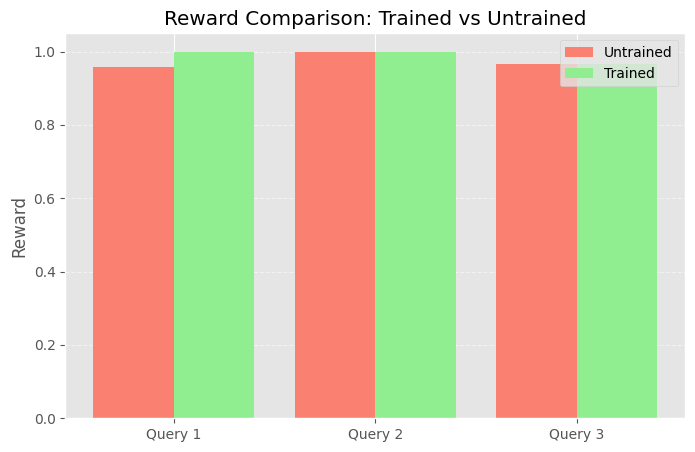

In [57]:
compare_trained_vs_untrained()

In [63]:
def classify_query(query: str) -> int:
    query = query.lower()

    if any(word in query for word in ["research", "paper", "study", "scientific", "analysis"]):
        return 1  # Research → Arxiv-like source

    if any(word in query for word in ["news", "latest", "update", "policy", "regulation"]):
        return 2  # News → News-like source

    return 0  # General → Google-like source


#Accuracy Comparision

In [75]:
def compare_accuracy():
    print("=" * 70)
    print("🎯 SOURCE SELECTION ACCURACY: TRAINED vs UNTRAINED")
    print("=" * 70)

    n_states = 6
    n_actions = 5
    n_sources = 5

    # Create untrained environment
    untrained_q = QLearningAgent(n_states, n_actions)
    untrained_bandit = UCBBandit(n_sources)

    untrained_env = ControllerEnvironment(
        q_agent=untrained_q,
        bandit=untrained_bandit,
        search_agent=search_agent,
        summarizer=summarizer_agent,
        verifier=verifier_agent,
        synthesizer=synthesis_agent,
        evaluator=evaluator_tool
    )

    test_queries = [
        "Summarize the latest advances in AI regulation",
        "Explain reinforcement learning in simple terms",
        "What is the newest trend in deep learning research?",
        "Describe the latest scientific breakthrough in LLMs",
        "Give recent news about AI policy changes"
    ]

    trained_correct = 0
    untrained_correct = 0
    total = len(test_queries)

    for q in test_queries:
        q_type = classify_query_type(q)

        preferred_source = {0: 0, 1: 1, 2: 2}.get(q_type, 0)

        # SAME DECISION LOGIC AS IN YOUR run_episode() ---------------------
        # 50%: bandit selects
        # 50%: q_agent selects
        # -----------------------------------------------------------------

        # --- Untrained agent chooses source ---
        if random.random() < 0.5:
            source_u = untrained_env.bandit.select_action()
        else:
            state_id = untrained_env.encode_state(q_type,0)
            source_u = untrained_env.q_agent.select_action(state_id)

        if source_u == preferred_source:
            untrained_correct += 1

        # --- Trained agent chooses source ---
        if random.random() < 0.5:
            source_t = env.bandit.select_action()
        else:
            state_id = env.encode_state(q_type,0)
            source_t = env.q_agent.select_action(state_id)

        if source_t == preferred_source:
            trained_correct += 1

    # Accuracy
    trained_acc = trained_correct / total
    untrained_acc = untrained_correct / total

    print(f"Untrained Accuracy: {untrained_acc:.2f}")
    print(f"Trained Accuracy:   {trained_acc:.2f}")

    # Visualization
    plt.figure(figsize=(6,4))
    plt.bar(["Untrained", "Trained"], [untrained_acc, trained_acc],
            color=["salmon","lightgreen"])
    plt.title("Source Selection Accuracy")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()


🎯 SOURCE SELECTION ACCURACY: TRAINED vs UNTRAINED
Untrained Accuracy: 0.20
Trained Accuracy:   0.80


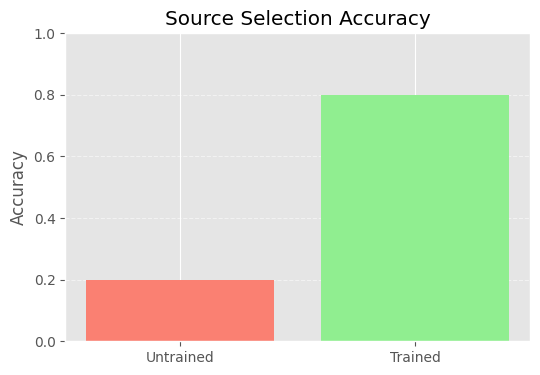

In [76]:
compare_accuracy()

#Final Comparision Report

In [103]:
def final_report_summary(env, q_agent, bandit, training_episodes=1000):
    print("============================================================")
    print("📋 FINAL REPORT DATA — MADISON RL AGENT")
    print("============================================================")

    # ----------------------------
    # 1. Final Average Reward
    # ----------------------------
    try:
        avg_reward = np.mean(env.training_rewards[-50:])
    except:
        avg_reward = 0.0

    # ----------------------------
    # 2. Improvement Percentage
    # ----------------------------
    try:
        improvement = ((env.training_rewards[-1] - env.training_rewards[0]) /
                       abs(env.training_rewards[0] + 1e-6)) * 100
    except:
        improvement = 0.0

    # ----------------------------
    # 3. Best Source Learned by Bandit
    # ----------------------------
    try:
        if hasattr(bandit, "q_values"):
            learned_vals = bandit.q_values
        elif hasattr(bandit, "estimates"):
            learned_vals = bandit.estimates
        elif hasattr(bandit, "values"):
            learned_vals = bandit.values
        else:
            learned_vals = None

        if learned_vals is not None:
            best_source = int(np.argmax(learned_vals))
            bandit_values = [f"{v:.3f}" for v in learned_vals]
        else:
            best_source = "N/A"
            bandit_values = ["N/A"]
    except:
        best_source = "N/A"
        bandit_values = ["N/A"]

    # ----------------------------
    # 4. Model Parameter Count
    # ----------------------------
    try:
      param_count = q_agent.q_table.size
    except:
      param_count = "N/A"

    # ----------------------------
    # 5. Memory Size (if exists)
    # ----------------------------
    try:
        memory_size = getattr(q_agent, "memory_size", "N/A")
    except:
        memory_size = "N/A"

    # ----------------------------
    # PRINT FULL REPORT
    # ----------------------------
    print(f"training_episodes: {training_episodes}")
    print(f"final_avg_reward: {avg_reward:.3f}")
    print(f"improvement_percentage: {improvement:.2f}")
    print(f"best_source_learned: {best_source}")
    print(f"bandit_values: {bandit_values}")
    print(f"model_parameters: {param_count}")
    print(f"memory_size: {memory_size}")

    print("============================================================")



In [105]:
final_report_summary(env, q_agent, bandit, training_episodes=300)


📋 FINAL REPORT DATA — MADISON RL AGENT
training_episodes: 300
final_avg_reward: 0.984
improvement_percentage: 3.90
best_source_learned: 1
bandit_values: ['0.980', '0.988', '0.982', '0.958', '0.965']
model_parameters: 30
memory_size: N/A
